In [3]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [1]:
%cd drive/MyDrive/drawing-reconstruction/

/content/drive/MyDrive/drawing-reconstruction


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, ContinuousBernoulli, kl_divergence

def reparametrize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class GaussianEncoder(nn.Module):
    """Convolutional encoder producing (mu, logvar)"""
    def __init__(self, in_channels, latent_dim, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.LeakyReLU(0.2),
        )

        # Automatically compute flattened dimension
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, input_dim, input_dim)
            h = self.net(dummy)
            self.flatten_dim = h.view(1, -1).size(1)

        self.mean = nn.Linear(self.flatten_dim, latent_dim)
        self.logvar = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        h = self.net(x)
        h = torch.flatten(h, 1)
        return self.mean(h), self.logvar(h)

class GaussianDecoder(nn.Module):
    """Decoder modeling p(x|z,y) with partial input conditioning"""
    def __init__(self, latent_dim, input_dim):
        super().__init__()
        self.init_channels = 128
        self.init_spatial = input_dim // 4  # match encoder downsampling

        # Project latent z to spatial feature map
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, self.init_channels * self.init_spatial * self.init_spatial),
            nn.LeakyReLU(0.2)
        )

        # Conv decoder
        self.trunk = nn.Sequential(
            nn.ConvTranspose2d(self.init_channels + 1, 64, 4, stride=2, padding=1),  # +1 for partial input
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.LeakyReLU(0.2),
        )

        self.mean_head = nn.Conv2d(32, 1, 3, padding=1)  # output logits for Bernoulli

    def forward(self, z, y):
        # z: [B, latent_dim]
        # y: [B, 1, H, W] partial input
        h = self.fc(z)
        h = h.view(z.size(0), self.init_channels, self.init_spatial, self.init_spatial)

        # Resize partial input to match latent spatial size
        y_resized = F.interpolate(y, size=(self.init_spatial, self.init_spatial), mode='bilinear', align_corners=False)

        # Concatenate along channel dimension
        h = torch.cat([h, y_resized], dim=1)  # now channels = init_channels + 1

        # Pass through conv trunk
        h = self.trunk(h)
        x_logits = self.mean_head(h)
        return x_logits

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=200, device="cpu"):
        super().__init__()
        self.latent_dim = latent_dim
        self.device = device

        self.encoder_prior = GaussianEncoder(in_channels=1, latent_dim=latent_dim, input_dim=input_dim)
        self.encoder_post = GaussianEncoder(in_channels=2, latent_dim=latent_dim, input_dim=input_dim)

        self.decoder = GaussianDecoder(latent_dim=latent_dim, input_dim=input_dim)

    def forward(self, x, y):
        mu_p, logvar_p = self.encoder_prior(y)

        xy = torch.cat([x, y], dim=1)
        mu_q, logvar_q = self.encoder_post(xy)

        z = reparametrize(mu_q, logvar_q)

        x_logits = self.decoder(z, y)
        x_prob = torch.sigmoid(x_logits)

        return z, mu_p, logvar_p, mu_q, logvar_q, x_logits, x_prob

    def sample(self, y):
        mu_p, logvar_p = self.encoder_prior(y)
        #z = reparametrize(mu_p, logvar_p)
        z = mu_p
        x_logits = self.decoder(z, y)
        return torch.sigmoid(x_logits)

    @staticmethod
    def loss(x, y, mu_p, logvar_p, mu_q, logvar_q, x_logits, beta=1.0):
        """CVAE ELBO loss"""
        recon_loss = F.binary_cross_entropy_with_logits(x_logits, x, reduction='none')
        recon_loss = recon_loss.flatten(1).mean(1)

        q_dist = Normal(mu_q, torch.exp(0.5 * logvar_q))
        p_dist = Normal(mu_p, torch.exp(0.5 * logvar_p))
        kl = kl_divergence(q_dist, p_dist).mean(1)

        loss = (recon_loss + beta * kl).mean()
        return loss


64
Found 1 files, in total 10000 entires
Dataset loaded
Train: 7000.000000, val: 1500.000000, test: 1500.000000
Epoch 1/40


/tmp/ipython-input-2120640621.py:133: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  grad_norm = np.sqrt(sum([torch.norm(p.grad)**2 for p in model.parameters()]).cpu())


-> Total epoch 1/40 loss_train: 0.398216, loss_val: 0.402762
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


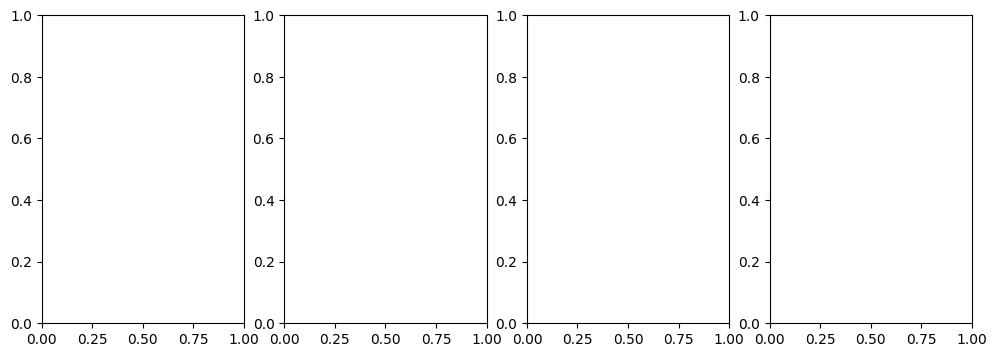

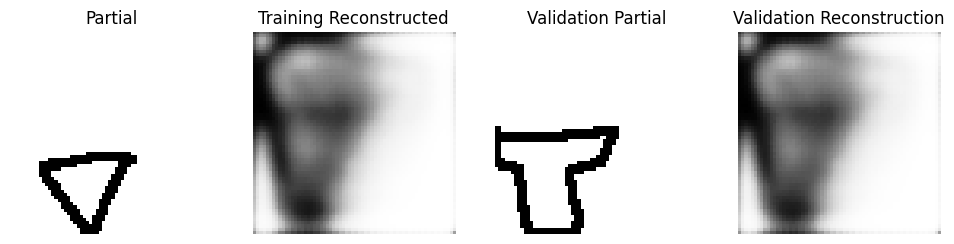

Max: 0.9998016953468323
Min: 0.4873758554458618
Model weights saved to checkpoint_0_ice_weights.pth
Epoch 2/40
-> Total epoch 2/40 loss_train: 0.343701, loss_val: 0.346833
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


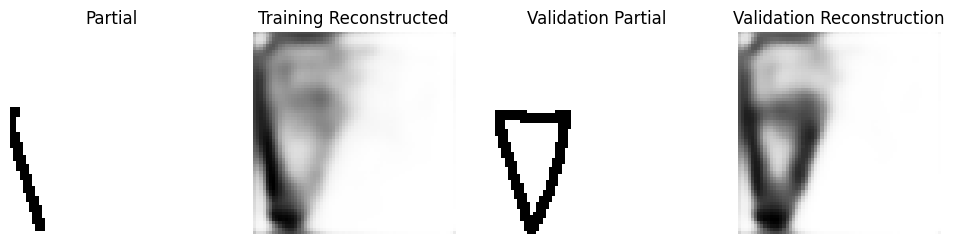

Max: 0.9999995231628418
Min: 0.31193748116493225
Epoch 3/40
-> Total epoch 3/40 loss_train: 0.285853, loss_val: 0.287060
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


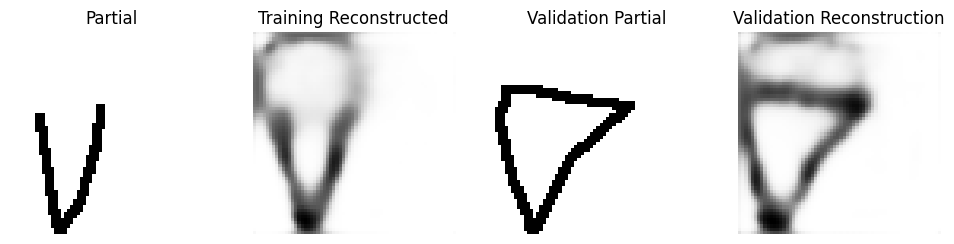

Max: 1.0
Min: 0.13470062613487244
Epoch 4/40
-> Total epoch 4/40 loss_train: 0.261132, loss_val: 0.264540
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


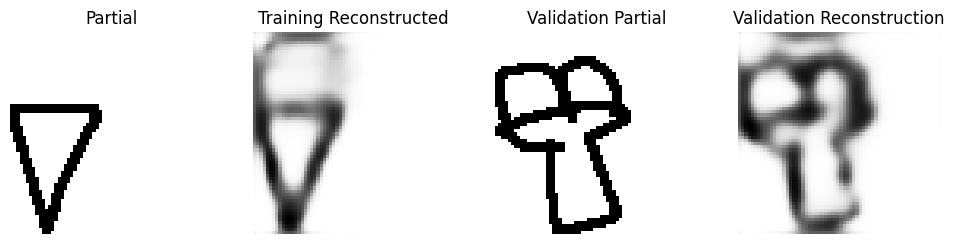

Max: 1.0
Min: 0.14226815104484558
Epoch 5/40
-> Total epoch 5/40 loss_train: 0.223582, loss_val: 0.227528
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


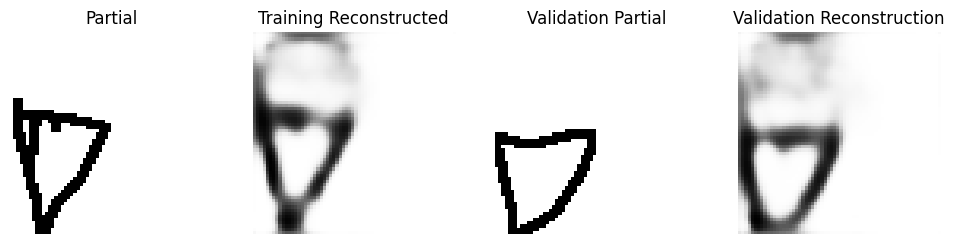

Max: 1.0
Min: 0.09114166349172592
Epoch 6/40
-> Total epoch 6/40 loss_train: 0.218534, loss_val: 0.222762
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


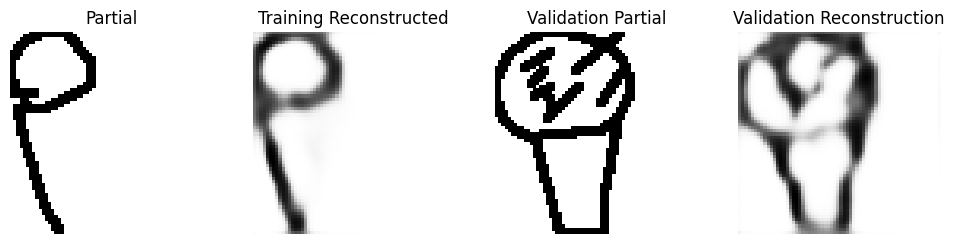

Max: 1.0
Min: 0.0618278868496418
Model weights saved to checkpoint_5_ice_weights.pth
Epoch 7/40
-> Total epoch 7/40 loss_train: 0.209960, loss_val: 0.214158
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


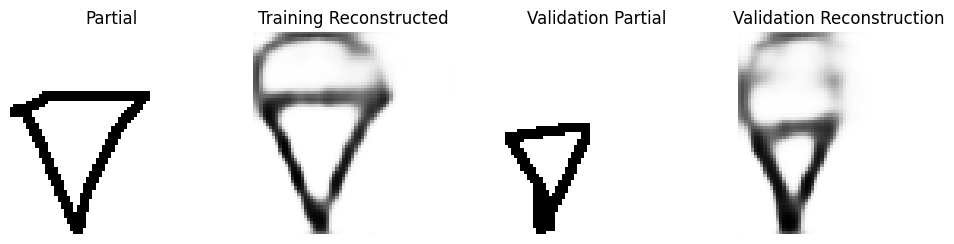

Max: 1.0
Min: 0.042244113981723785
Epoch 8/40
-> Total epoch 8/40 loss_train: 0.194011, loss_val: 0.198890
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


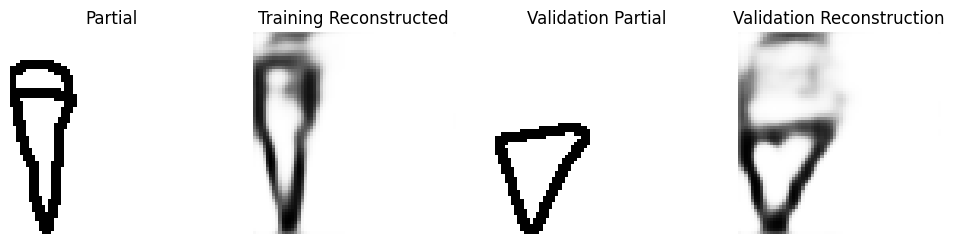

Max: 1.0
Min: 0.05032426491379738
Epoch 9/40
-> Total epoch 9/40 loss_train: 0.198347, loss_val: 0.203592
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


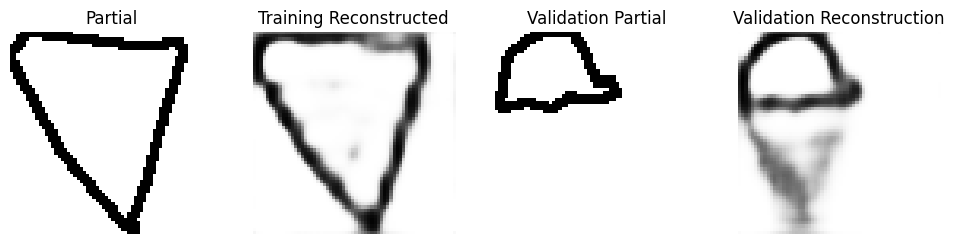

Max: 1.0
Min: 0.018945876508951187
Epoch 10/40
-> Total epoch 10/40 loss_train: 0.228299, loss_val: 0.233776
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


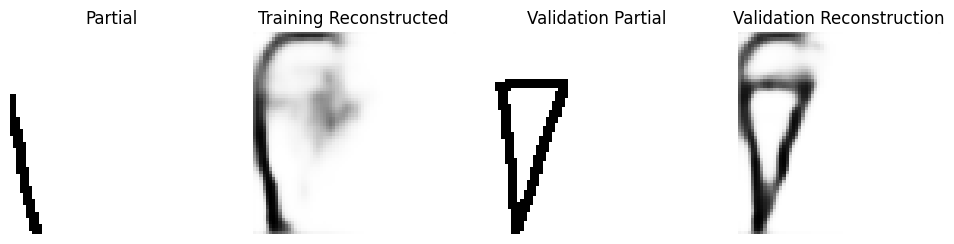

Max: 1.0
Min: 0.02435236983001232
Epoch 11/40
-> Total epoch 11/40 loss_train: 0.192973, loss_val: 0.199607
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


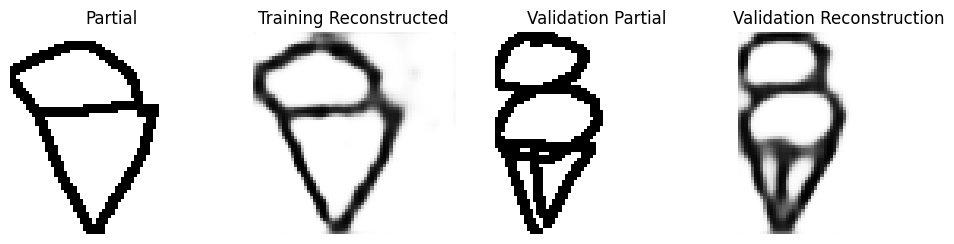

Max: 1.0
Min: 0.004882124252617359
Model weights saved to checkpoint_10_ice_weights.pth
Epoch 12/40
-> Total epoch 12/40 loss_train: 0.188876, loss_val: 0.195938
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


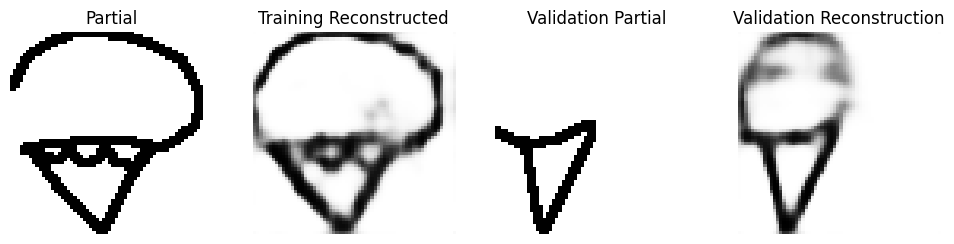

Max: 1.0
Min: 0.005255978554487228
Epoch 13/40
-> Total epoch 13/40 loss_train: 0.170982, loss_val: 0.178034
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


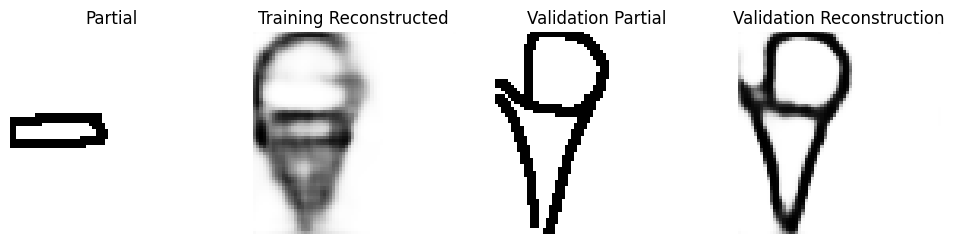

Max: 1.0
Min: 0.030621565878391266
Epoch 14/40
-> Total epoch 14/40 loss_train: 0.177507, loss_val: 0.184715
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


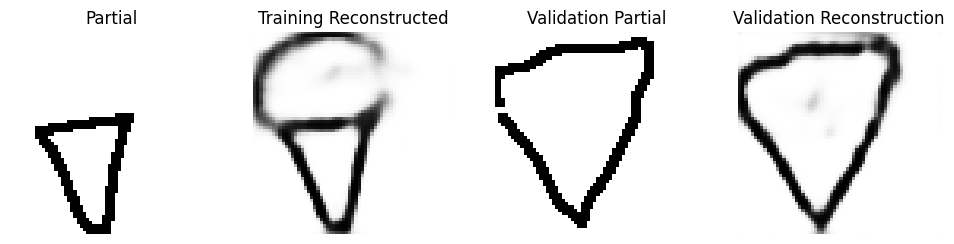

Max: 1.0
Min: 0.0012637609615921974
Epoch 15/40
-> Total epoch 15/40 loss_train: 0.174827, loss_val: 0.182126
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


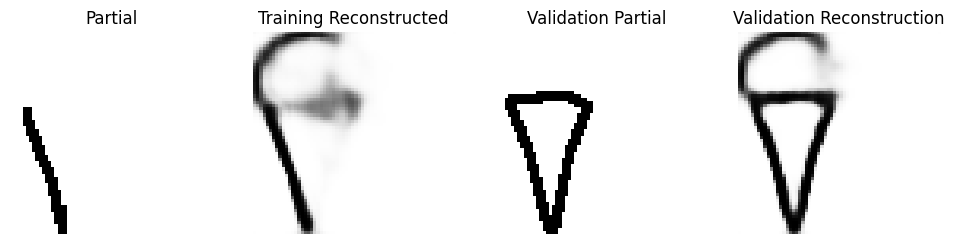

Max: 1.0
Min: 0.0005637741996906698
Epoch 16/40
-> Total epoch 16/40 loss_train: 0.176449, loss_val: 0.185010
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


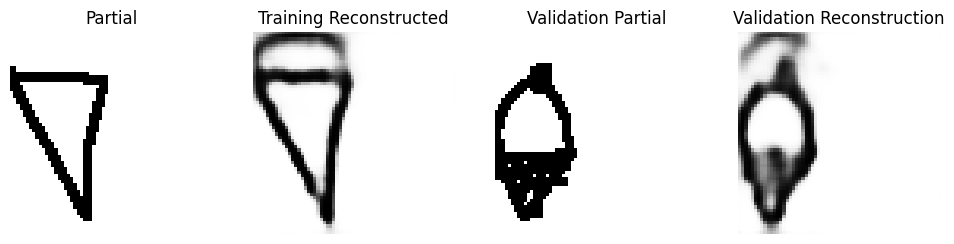

Max: 1.0
Min: 0.00017417890194337815
Model weights saved to checkpoint_15_ice_weights.pth
Epoch 17/40
-> Total epoch 17/40 loss_train: 0.174933, loss_val: 0.183672
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


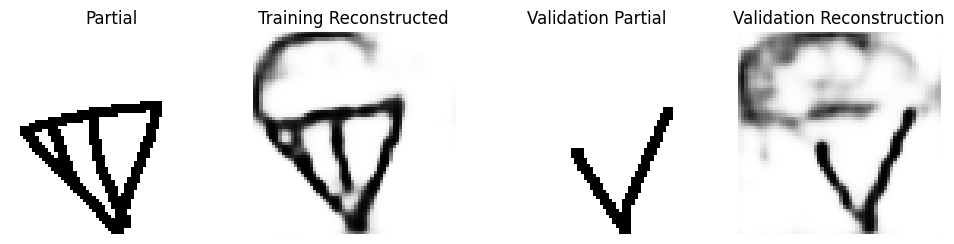

Max: 1.0
Min: 0.0017685705097392201
Epoch 18/40
-> Total epoch 18/40 loss_train: 0.159588, loss_val: 0.168565
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


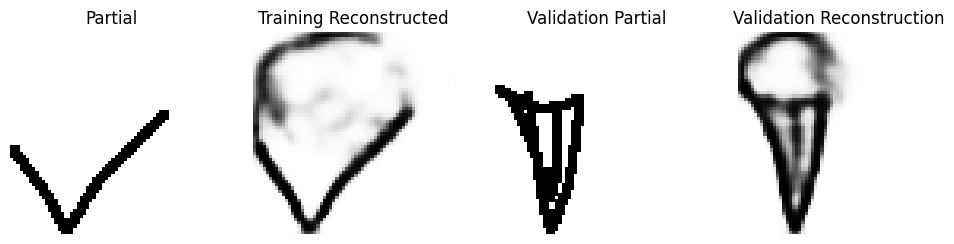

Max: 1.0
Min: 0.0005614426336251199
Epoch 19/40
-> Total epoch 19/40 loss_train: 0.159565, loss_val: 0.168947
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


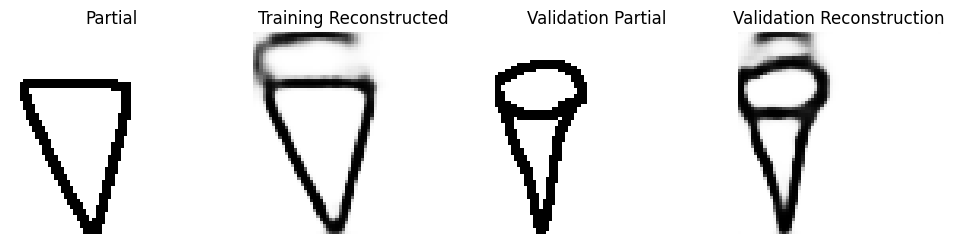

Max: 1.0
Min: 0.0001395169529132545
Epoch 20/40
-> Total epoch 20/40 loss_train: 0.156914, loss_val: 0.166981
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


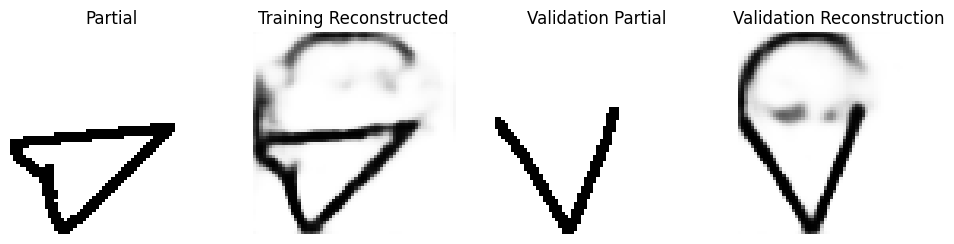

Max: 1.0
Min: 7.549164001829922e-05
Epoch 21/40
-> Total epoch 21/40 loss_train: 0.153376, loss_val: 0.163076
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


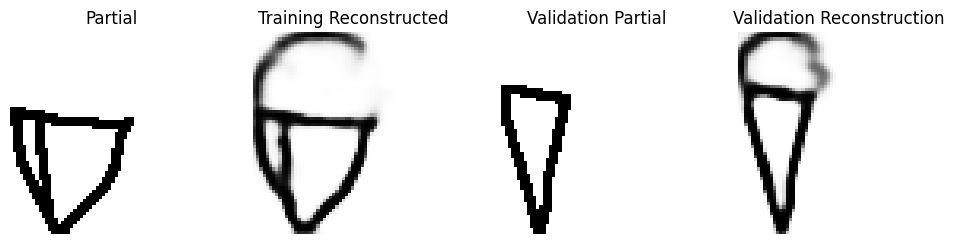

Max: 1.0
Min: 0.0004096539632882923
Model weights saved to checkpoint_20_ice_weights.pth
Epoch 22/40
-> Total epoch 22/40 loss_train: 0.158332, loss_val: 0.169214
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


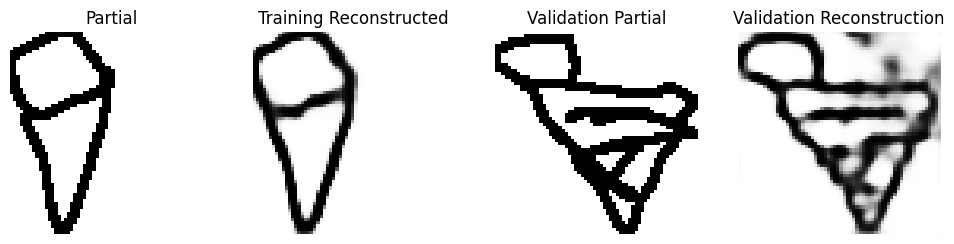

Max: 1.0
Min: 1.2287623576412443e-05
Epoch 23/40
-> Total epoch 23/40 loss_train: 0.152215, loss_val: 0.162986
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


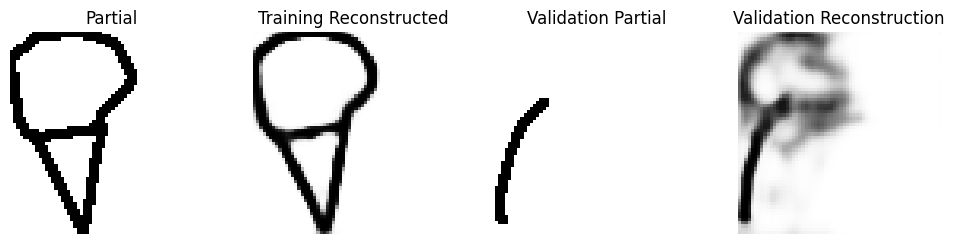

Max: 1.0
Min: 1.3304344975040294e-05
Epoch 24/40
-> Total epoch 24/40 loss_train: 0.153804, loss_val: 0.164537
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


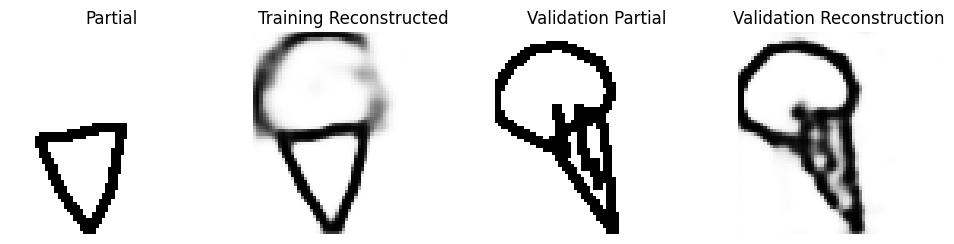

Max: 1.0
Min: 0.00012182360660517588
Epoch 25/40
-> Total epoch 25/40 loss_train: 0.149501, loss_val: 0.161397
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


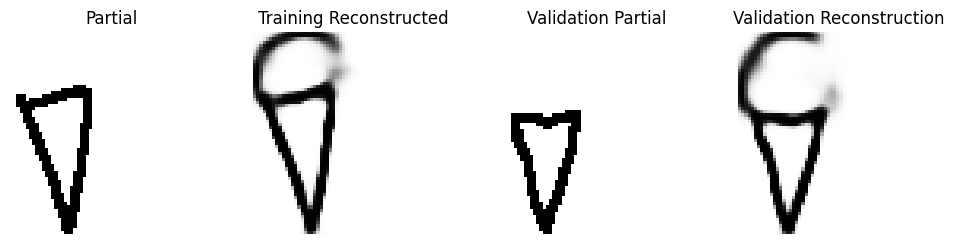

Max: 1.0
Min: 1.2610529665835202e-05
Epoch 26/40
-> Total epoch 26/40 loss_train: 0.153391, loss_val: 0.164889
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


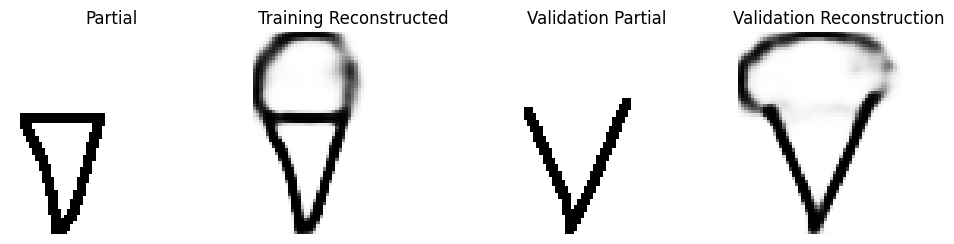

Max: 1.0
Min: 1.3123527423886117e-05
Model weights saved to checkpoint_25_ice_weights.pth
Epoch 27/40
-> Total epoch 27/40 loss_train: 0.143274, loss_val: 0.156009
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


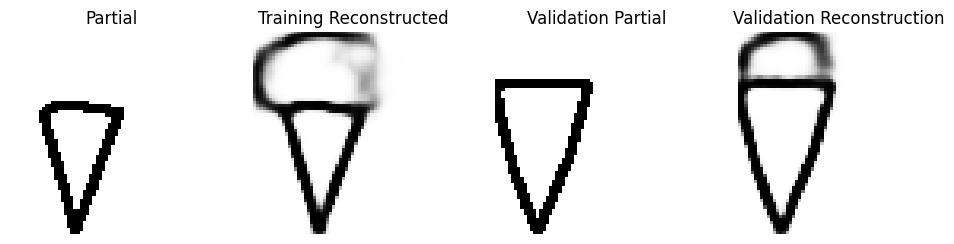

Max: 1.0
Min: 8.371492185688112e-06
Epoch 28/40
-> Total epoch 28/40 loss_train: 0.159248, loss_val: 0.173199
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


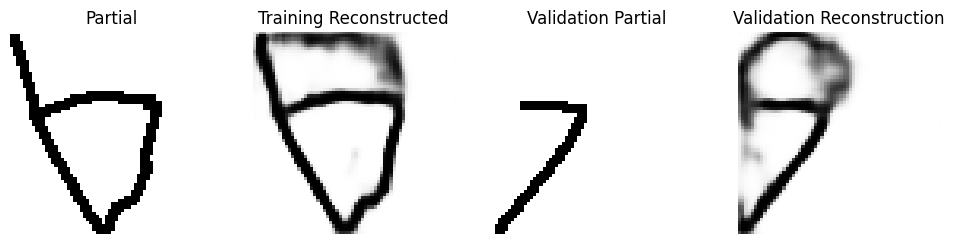

Max: 1.0
Min: 6.843175015092129e-06
Epoch 29/40
-> Total epoch 29/40 loss_train: 0.160734, loss_val: 0.175645
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


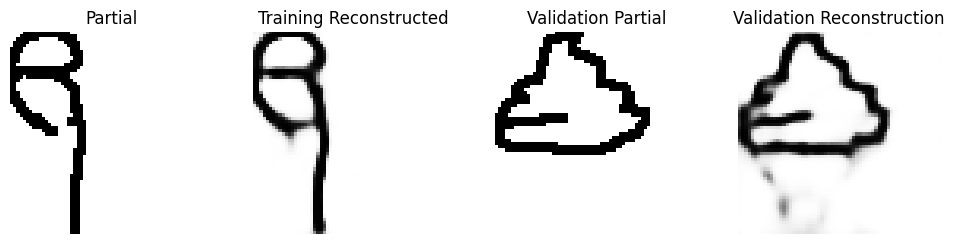

Max: 1.0
Min: 1.1366611033736262e-05
Epoch 30/40
-> Total epoch 30/40 loss_train: 0.147875, loss_val: 0.161502
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


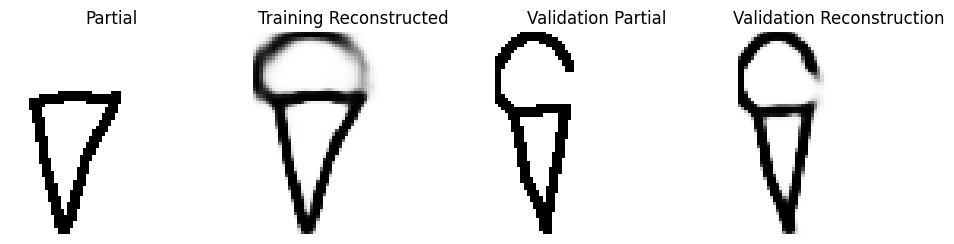

Max: 1.0
Min: 4.097757937415736e-06
Epoch 31/40
-> Total epoch 31/40 loss_train: 0.139859, loss_val: 0.153895
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


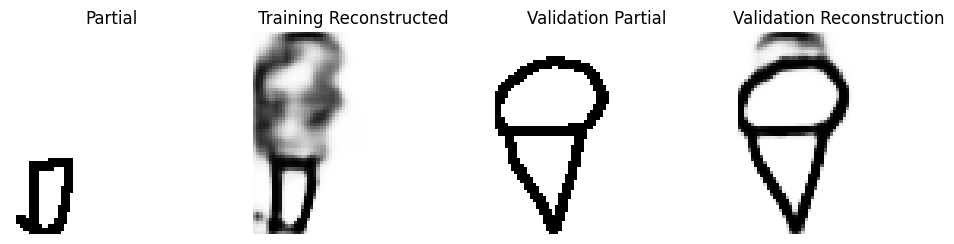

Max: 1.0
Min: 9.483790927333757e-05
Model weights saved to checkpoint_30_ice_weights.pth
Epoch 32/40
-> Total epoch 32/40 loss_train: 0.136534, loss_val: 0.150003
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


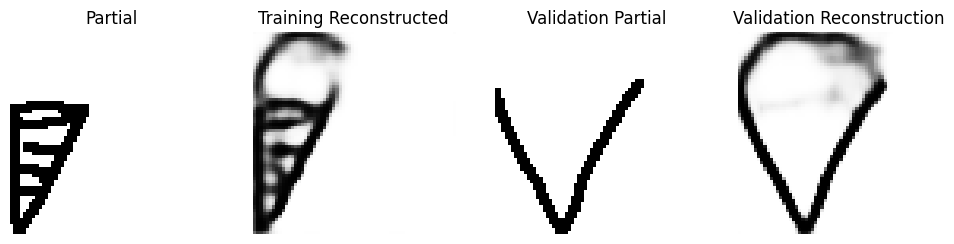

Max: 1.0
Min: 0.00046423051389865577
Epoch 33/40
-> Total epoch 33/40 loss_train: 0.135923, loss_val: 0.149621
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


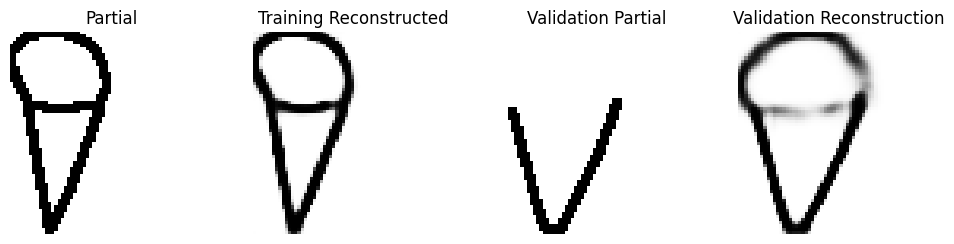

Max: 1.0
Min: 1.7921091455264104e-07
Epoch 34/40
-> Total epoch 34/40 loss_train: 0.138431, loss_val: 0.154256
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


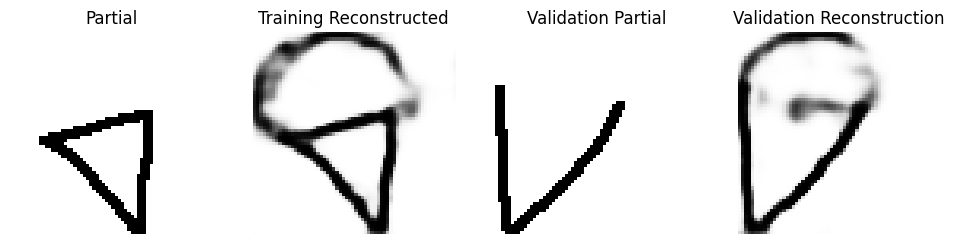

Max: 1.0
Min: 0.0003121976333204657
Epoch 35/40
-> Total epoch 35/40 loss_train: 0.142956, loss_val: 0.158014
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


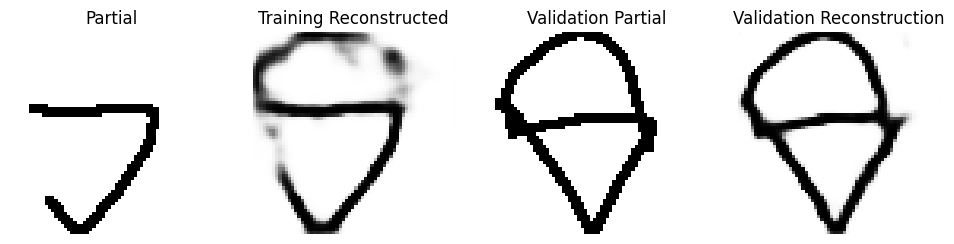

Max: 1.0
Min: 5.480313120642677e-05
Epoch 36/40
-> Total epoch 36/40 loss_train: 0.135776, loss_val: 0.153123
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


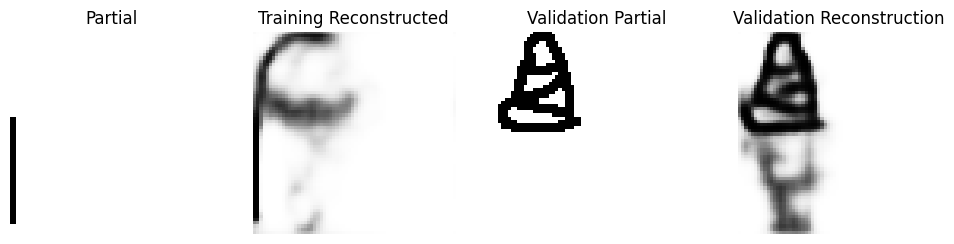

Max: 1.0
Min: 0.0007256948738358915
Model weights saved to checkpoint_35_ice_weights.pth
Epoch 37/40
-> Total epoch 37/40 loss_train: 0.148258, loss_val: 0.166616
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


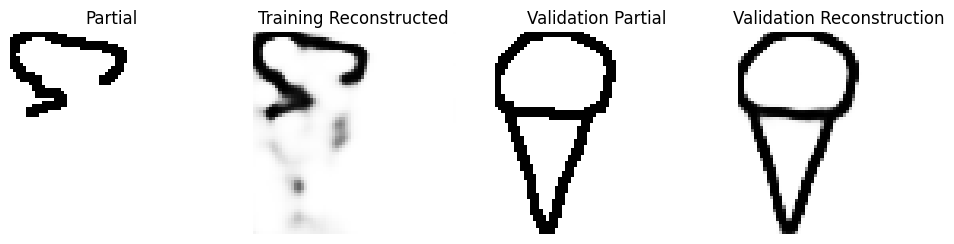

Max: 1.0
Min: 3.985463990829885e-05
Epoch 38/40
-> Total epoch 38/40 loss_train: 0.144843, loss_val: 0.163740
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


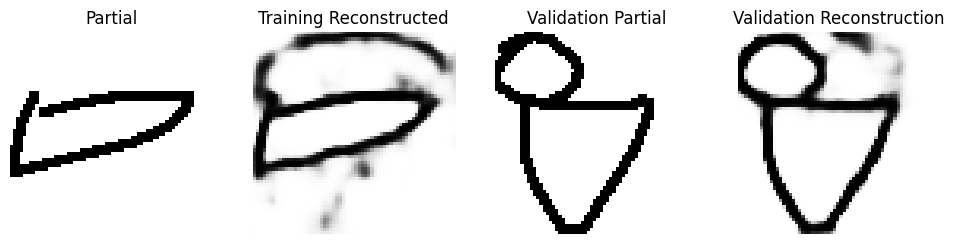

Max: 1.0
Min: 1.8170252587879077e-05
Epoch 39/40
-> Total epoch 39/40 loss_train: 0.138525, loss_val: 0.156917
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


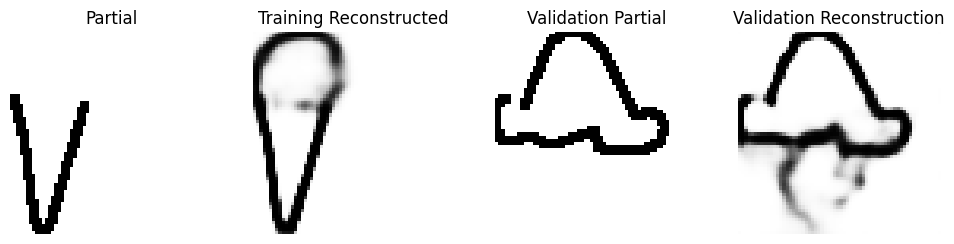

Max: 1.0
Min: 1.3206233973050985e-07
Epoch 40/40
-> Total epoch 40/40 loss_train: 0.127582, loss_val: 0.146212
before torch.Size([24, 1, 64, 64])
torch.Size([64, 64])


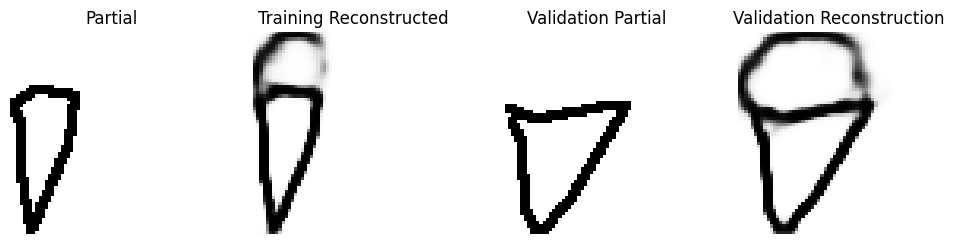

Max: 1.0
Min: 8.827577175907209e-07


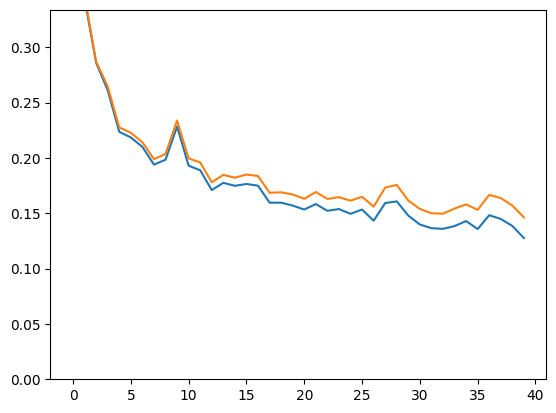

Final losses: train - 0.127552, val - 0.146152, test - 0.144320
Model weights saved to ice_weights.pth


TypeError: VAE.forward() missing 1 required positional argument: 'y'

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("scripts")

#from cvae_model_decoderz2 import CVAE as VAE
from dataset import ImageDataset

# ---------------------------------------------------------------------
# Global variables
# ---------------------------------------------------------------------

dataset_dir = "quickdraw"
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
image_limit = 10000
image_size = (64, 64)
binarization_threshold = 0.55
model_weights_save_path = "ice_weights.pth"
#item = "cat"
item = "ice cream"
model_residual = False
latent_dim  = 128
checkpointing = True

config = {
    "epochs": 40,
    "lr": 1e-4,
    "weight_decay": 1e-8,
    "grad_clip": 0.01,
    "loss": VAE.loss
    #"loss": nn.L1Loss(),
}

# ---------------------------------------------------------------------
# Helper functions
# ---------------------------------------------------------------------

def get_y(x, out):
    if model_residual:
        return torch.min(x, 1-out)
    return out

def eval_loss(loader, loss):
    model.eval()

    L_total = 0
    total_samples = 0

    with torch.no_grad():
        for X, y_, cats in loader:
            X = y_.to(device, dtype=torch.float32)
            X = X.unsqueeze(1)
            y_ = y_.unsqueeze(1)
            y_ = y_.to(device, dtype=torch.float32)
            z, mu_p, logvar_p, mu_q, logvar_q, x_logits, x_prob = model(y_, X)
            batch_size = X.size(0)
            L_total += loss(y_, X, mu_p, logvar_p, mu_q, logvar_q, x_logits, beta=1.0).item() * batch_size
            total_samples += batch_size

    return L_total / total_samples

def visualize(axarr, images, titles, figsize=(12, 4)):
    n = len(images)
    assert n == len(titles), "Number of images and titles must match"

    # Ensure tuple of floats
    figsize = tuple(float(x) for x in figsize)

    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap="Greys_r")
        plt.title(title)
        plt.axis('off')
    plt.show()


def binarize(img, binarization_threshold=binarization_threshold):
    binary = np.ones_like(img, dtype=np.float32)
    binary[img < binarization_threshold] = 0
    return binary

def save_model(model, model_weights_save_path=model_weights_save_path):
    torch.save(model.state_dict(), model_weights_save_path)
    print(f"Model weights saved to {model_weights_save_path}")

# ---------------------------------------------------------------------
# Train function
# ---------------------------------------------------------------------

def train(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, config):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    model = model.to(device)
    Ls_train = []
    Ls_val = []
    grad_norms = []
    epochs = int(config["epochs"])

    plt.ion()
    n_graphs = 4
    f, axarr = plt.subplots(1, n_graphs, figsize=(3 * n_graphs, 4))
    t = time.time()
    loss = config["loss"]
    #betas = np.linspace(0, 1, 5)
    #beta = 0

    try:
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            model.train()

            for i, (X_imgs, y_, cats) in enumerate(train_loader):
                optimizer.zero_grad()

                X = X_imgs.to(device, dtype=torch.float32)
                y_ = y_.to(device, dtype=torch.float32)
                X = X.unsqueeze(1)
                y_ = y_.unsqueeze(1)

                z, mu_p, logvar_p, mu_q, logvar_q, x_logits, x_prob = model(y_, X)

                L = loss(y_, X, mu_p, logvar_p, mu_q, logvar_q, x_logits, beta=0.1)

                L.backward()
                if config["grad_clip"] is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])
                grad_norm = np.sqrt(sum([torch.norm(p.grad)**2 for p in model.parameters()]).cpu())
                optimizer.step()

                #print(f"---> {i+1}/{len(train_loader)}, loss: {L:.6f}, grad_norm: {grad_norm:.6f}")

            L_train = eval_loss(train_loader, loss)
            L_val = eval_loss(val_loader, loss)
            Ls_train.append(L_train)
            Ls_val.append(L_val)



            print(f"-> Total epoch {epoch+1}/{epochs} loss_train: {L_train:.6f}, loss_val: {L_val:.6f}")

            img_original = X_imgs[0].cpu().detach().numpy()
            print(f"before {y_.shape}")

            img_new = model.sample(X[0].unsqueeze(0))
            img_new = img_new.squeeze(0).squeeze(0)
            img_new = img_new.detach().cpu().numpy()
            img_new_b = binarize(img_new)

            X_val_imgs, y_, _ = next(iter(val_loader))
            X_val = X_val_imgs[0]
            X_val = X_val.to(X.device)
            X_val = X_val.to(X.dtype)
            print(X_val.shape)

            img_val = model.sample(X_val.unsqueeze(0).unsqueeze(0))
            img_val_original = X_val.squeeze(0)
            img_val = img_val.squeeze(0).squeeze(0)
            img_val_reconstructed = img_val.detach().cpu().numpy()
            img_val_original = img_val_original.detach().cpu().numpy()
            if time.time() - t >= 1:
                t = time.time()
                try:
                    f.canvas.manager.set_window_title(f"Epoch {epoch}")
                except:
                    pass
                visualize(
                    axarr,
                    [img_original, img_new, img_val_original, img_val_reconstructed],
                    ["Partial", "Training Reconstructed", "Validation Partial", "Validation Reconstruction"]
                )
                plt.pause(0.01)
                print(f"Max: {np.max(img_new)}")
                print(f"Min: {np.min(img_new)}")

            if epoch % 5 == 0 and checkpointing:
                save_model(model, f"checkpoint_{epoch}_{model_weights_save_path}")



    except KeyboardInterrupt:
        print("Early stop")

    plt.ioff()
    plt.close()

    plt.plot(Ls_train, label="Train Losses")
    plt.plot(Ls_val, label="Val Losses")
    vals = sorted(Ls_train + Ls_val)
    cutoff = vals[int(0.5 * len(vals))] * 2
    plt.ylim(0, cutoff)
    plt.show()


# ---------------------------------------------------------------------
# Main
# ---------------------------------------------------------------------

if __name__ == "__main__":
    print(image_size[0])
    model = VAE(image_size[0], latent_dim, torch.device(device))

    dataset = ImageDataset(dataset_dir, image_size, image_limit, item=item)
    print("Dataset loaded")

    train_set, val_set, test_set = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

    print(f"Train: {len(train_set):.6f}, val: {len(val_set):.6f}, test: {len(test_set):.6f}")

    train(model, train_loader, val_loader, config)

    loss = config["loss"]

    L_train = eval_loss(train_loader, loss)
    L_val = eval_loss(val_loader, loss)
    L_test = eval_loss(test_loader, loss)

    print(f"Final losses: train - {L_train:.6f}, val - {L_val:.6f}, test - {L_test:.6f}")

    save_model(model)

    try:
        while True:
            i = np.random.randint(0, len(test_set))
            img_partial, img_full, cat = test_set[i]
            x = img_partial.reshape((1, image_size[0] * image_size[1]))
            xd = x.to(device, dtype=torch.float32)
            y_d = img_full.to(device, dtype=torch.float32)
            with torch.no_grad():
                outd, _, _ = model(xd)
                yd = get_y(xd, outd)
                yd = yd.reshape(image_size)
            y = yd.cpu()

            L = loss(yd, y_d)
            print(f"Loss: {L}")

            img_reconstructed = y
            img_reconstructed_binary = binarize(img_reconstructed)

            n_graphs = 4
            f, axarr = plt.subplots(1, n_graphs, figsize=(3 * n_graphs, 4))
            visualize(
                axarr,
                [img_partial, img_full, img_reconstructed, img_reconstructed_binary],
                ["Partial", "Full", "Reconstructed", "Binarized"]
            )
            plt.show()

    except KeyboardInterrupt:
        print("Done")


In [2]:
!python scripts/train_cvae.py

64
Found 1 files, in total 10000 entires
Dataset loaded
Train: 7000.000000, val: 1500.000000, test: 1500.000000
Epoch 1/40
/content/drive/MyDrive/drawing-reconstruction/scripts/train_cvae.py:131: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  grad_norm = np.sqrt(sum([torch.norm(p.grad)**2 for p in model.parameters()]).cpu())
Early stop
Traceback (most recent call last):
  File "/content/drive/MyDrive/drawing-reconstruction/scripts/train_cvae.py", line 216, in <module>
    train(model, train_loader, val_loader, config)
  File "/content/drive/MyDrive/drawing-reconstruction/scripts/train_cvae.py", line 193, in train
    cutoff = vals[int(0.5 * len(vals))] * 2
             ~~~~^^^^^^^^^^^^^^^^^^^^^^
IndexError: list index out of range


In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Normal, kl_divergence
import torch.nn.functional as F
import sys
sys.path.append("scripts")
from cvae_model_decoderz import CVAE
from dataset import ImageDataset

# ---------------------------------------------------------------------
# Config
# ---------------------------------------------------------------------

dataset_dir = "quickdraw"
image_size = (64, 64)
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 128
item = "ice cream"
model_weights_path = "ice_weights.pth"

# ---------------------------------------------------------------------
# Load model
# ---------------------------------------------------------------------

model = CVAE(image_size[0], latent_dim, device)
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model.to(device)
model.eval()
image_limit = 100

# ---------------------------------------------------------------------
# Load dataset
# ---------------------------------------------------------------------

dataset = ImageDataset(dataset_dir, image_size, image_limit=image_limit, item=item)
_, _, test_set = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False
)

# ---------------------------------------------------------------------
# Evaluation loop
# ---------------------------------------------------------------------

recon_losses = []
kl_losses = []

with torch.no_grad():
    for X_imgs, y_, _ in test_loader:
        x = X_imgs.to(device, dtype=torch.float32).unsqueeze(1)
        y = y_.to(device, dtype=torch.float32).unsqueeze(1)

        z, mu_p, logvar_p, mu_q, logvar_q, x_logits, _ = model(y, x)

        # Reconstruction loss
        recon = F.binary_cross_entropy_with_logits(
            x_logits, y, reduction="none"
        )
        recon = recon.flatten(1).mean(1)

        # KL divergence
        q = Normal(mu_q, torch.exp(0.5 * logvar_q))
        p = Normal(mu_p, torch.exp(0.5 * logvar_p))
        kl = kl_divergence(q, p).mean(1)

        recon_losses.append(recon.cpu())
        kl_losses.append(kl.cpu())

# ---------------------------------------------------------------------
# Report metrics
# ---------------------------------------------------------------------

recon_loss = torch.cat(recon_losses).mean().item()
kl_loss = torch.cat(kl_losses).mean().item()
elbo = recon_loss + kl_loss

print("========== Test Set Evaluation ==========")
print(f"Reconstruction Loss (BCE): {recon_loss:.6f}")
print(f"KL Divergence:             {kl_loss:.6f}")
print(f"ELBO:                      {elbo:.6f}")

# ---------------------------------------------------------------------
# Qualitative evaluation
# ---------------------------------------------------------------------

def visualize_results(model, loader, n=4):
    model.eval()
    X_imgs, y_, _ = next(iter(loader))
    x = X_imgs[:n].to(device, dtype=torch.float32).unsqueeze(1)
    y = y_[:n].to(device, dtype=torch.float32).unsqueeze(1)

    with torch.no_grad():
        mu_p, logvar_p = model.encoder_prior(x)
        z = mu_p + torch.randn_like(mu_p) * torch.exp(0.5 * logvar_p)
        recon = torch.sigmoid(model.decoder(z))

    fig, axes = plt.subplots(n, 3, figsize=(9, 3 * n))

    for i in range(n):
        axes[i, 0].imshow(x[i, 0].cpu(), cmap="gray")
        axes[i, 0].set_title("Partial Input")
        axes[i, 1].imshow(recon[i, 0].cpu(), cmap="gray")
        axes[i, 1].set_title("Reconstruction")
        axes[i, 2].imshow(y[i, 0].cpu(), cmap="gray")
        axes[i, 2].set_title("Ground Truth")

        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

visualize_results(model, test_loader)


RuntimeError: Error(s) in loading state_dict for CVAE:
	size mismatch for decoder.trunk.0.weight: copying a param with shape torch.Size([129, 64, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 64, 4, 4]).